<h1 align="center"> Credit Fraud Detector </h1>

1. Load data
2. Data Wrangling
    1. Scaling
    2. UnderSampling/OverSampling
    3. Correlation Matrices
    4. Anomaly Detection
    5. Dimensionality Reduction and Clustering
3. Model development
4. Testing phase
5. How/why does the model predict

## About Dataset

#### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Đã được giảm chiều dữ liệu xuống còn 28 trường thông tin, đã scale phân tích thành phần chính (Principal Components Analysis - PCA)

Target là trường Class = 0 hoặc 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [7]:
import time

import matplotlib.patches as mpatches #dataaviz
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_recall_curve, precision_score,
                             average_precision_score, confusion_matrix,
                             recall_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [4]:
SEED = 10

# 1. Load data

In [3]:
df = pd.read_csv('creditcard.csv.zip', compression = 'zip')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.473120e-16  8.042109e-16  5.282512e-16  4.456271e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.426896e-15  1.701640e-15 -3.662252e-16 -1.217809e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

# 2. Data Wrangling

In [5]:
# No missing values
df.isnull().sum().max()

0

In [6]:
# The classes are heavily skewed
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud.

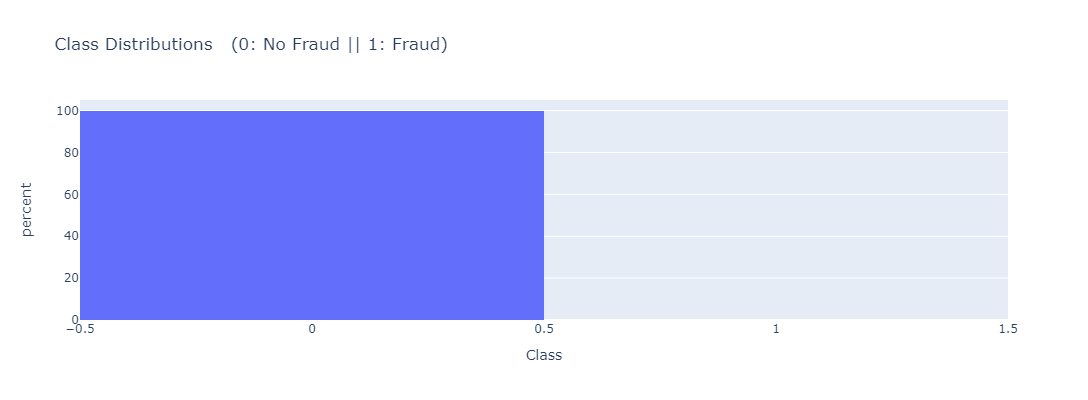

In [8]:
fig = px.histogram(df, x="Class", title='Class Distributions \n (0: No Fraud || 1: Fraud)', histnorm='percent', width=700, height=400)
fig.show()

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features.

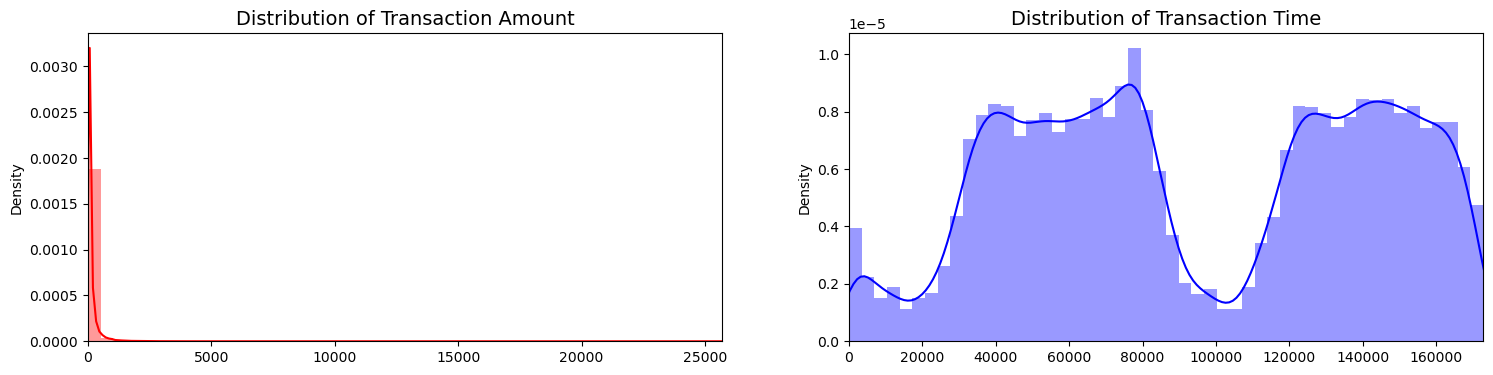

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

## 2.1. Scaling
-  <b>Scaled amount </b> and <b> scaled time </b> are the columns with scaled values.
- There are <b>492 cases </b> of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe.
- We concat the 492 cases of fraud and non fraud, <b>creating a new sub-sample </b>

In [9]:
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df.insert(0, 'scaled_amount', rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)))
df.insert(1, 'scaled_time', rob_scaler.fit_transform(df['Time'].values.reshape(-1,1)))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [10]:
df.head()

scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053      0  
1  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724      0  
2  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752      0  
3 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458      0  
4 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153      0  

[5 rows x 31 columns]

### Splitting the Data (Original DataFrame)

In [11]:
X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state= SEED, stratify=y)
#tham số stratify để chia train test sao cho tỷ lệ giống nhau
# c2 là stratify kfold

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


## 2.2. Random Under-Sampling
In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li> Bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>


Có thể sử dụng thư viện imbalance import random under-sampling

import imbalanced-learn as imblearn 

from imblearn.under_sampling import RandomUnderSampler

In [12]:
# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1, random_state = SEED) #sample để shuffle

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # vì có 492 qsat có nhãn số 1 

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state= SEED)

new_df.head()

scaled_amount  scaled_time         V1        V2         V3         V4  \
89190       19.285405    -0.261105  -5.344665 -0.285760  -3.835616   5.337048   
10204       -0.148257    -0.809161  -4.641893  2.902086  -1.572939   2.507299   
249887      -0.181793     0.821556  -3.393010  2.768455  -2.241902  -0.969099   
30314       -0.201076    -0.573620  -2.044489  3.368306  -3.937111   5.623120   
11710       -0.293440    -0.759889 -14.724627  7.875157 -21.872317  11.906170   

              V5        V6         V7        V8  ...       V20       V21  \
89190  -7.609909  3.874668   1.289630  0.201742  ... -1.562162  0.276011   
10204  -0.871783 -1.040903  -1.593901 -3.254905  ... -0.465679  1.963597   
249887 -1.031190 -1.006367  -0.670649  1.803644  ...  0.319923 -0.387810   
30314  -3.079232 -1.253474  -5.778880  1.707428  ...  1.112028  1.483594   
11710  -8.348734 -2.262846 -15.833443  0.077874  ...  0.996469 -2.362345   

             V22       V23       V24       V25       V26       V27       V28  \
89190   1.342045 -1.016579 -0.071361 -0.335869  0.441044  1.520613 -1.115937   
10204  -0.217414 -0.549340  0.645545 -0.354558 -0.611764 -3.908080 -0.671248   
249887 -0.841171  0.434634 -0.477667  0.040475  0.204249  0.597125  0.394418   
30314   0.834311 -0.148486  0.001669 -0.038996  0.389526  1.300236  0.549940   
11710   1.099557  1.037199 -1.036359 -0.254777  0.642343  2.161129 -1.401282   

        Class  
89190       1  
10204       1  
249887      0  
30314       1  
11710       1  

[5 rows x 31 columns]

In [13]:
colors = ['#0303fc', '#fc0303']

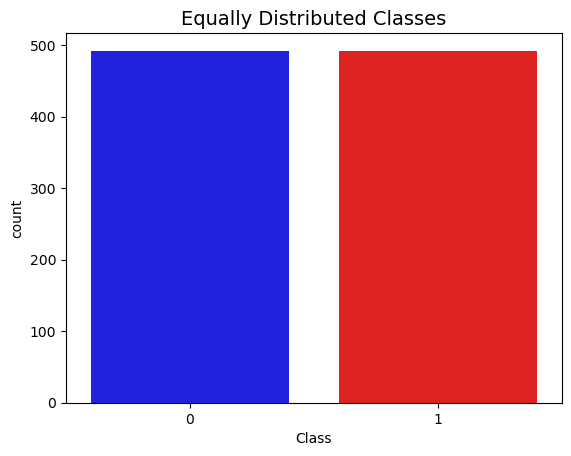

In [14]:
sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 2.3. Correlation Matrices
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary:
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

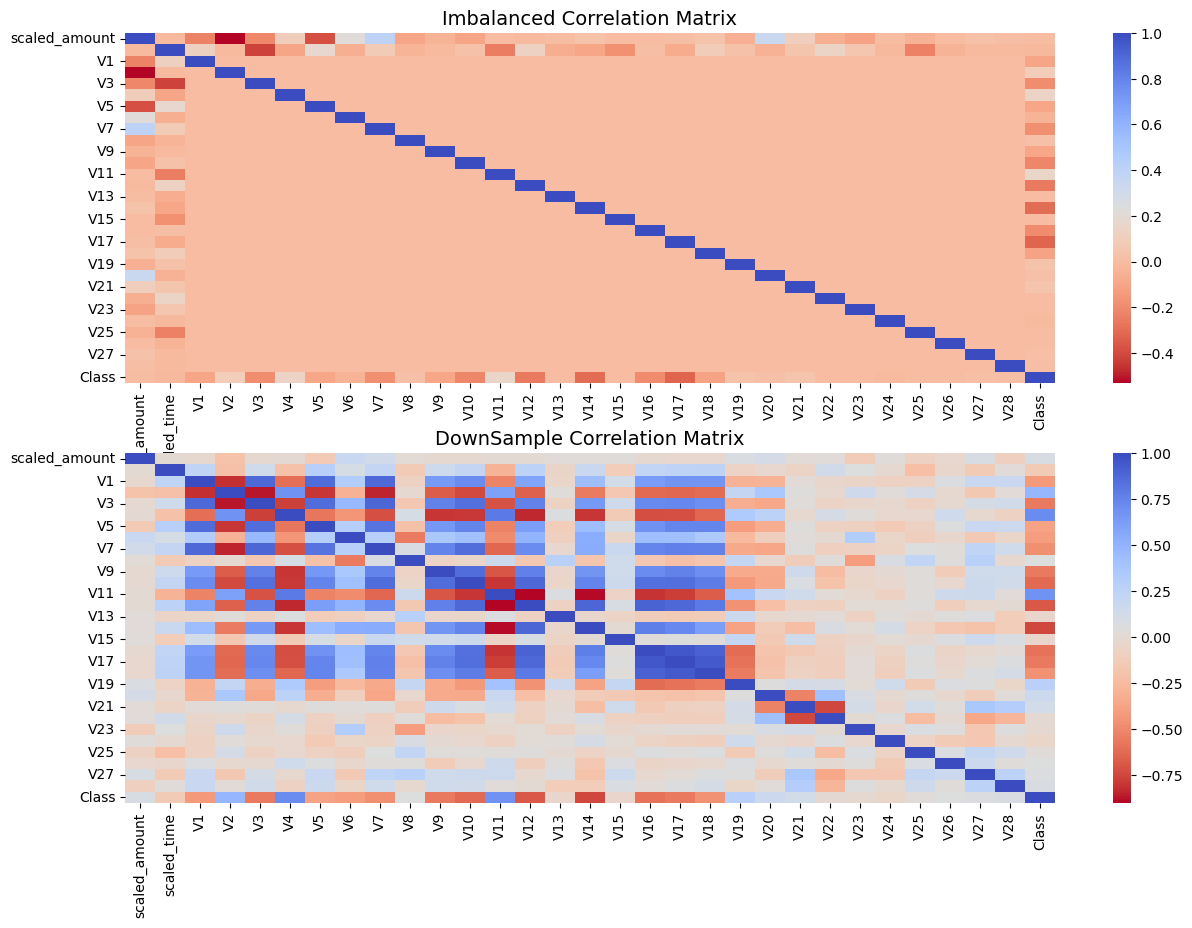

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('DownSample Correlation Matrix', fontsize=14)
plt.show()

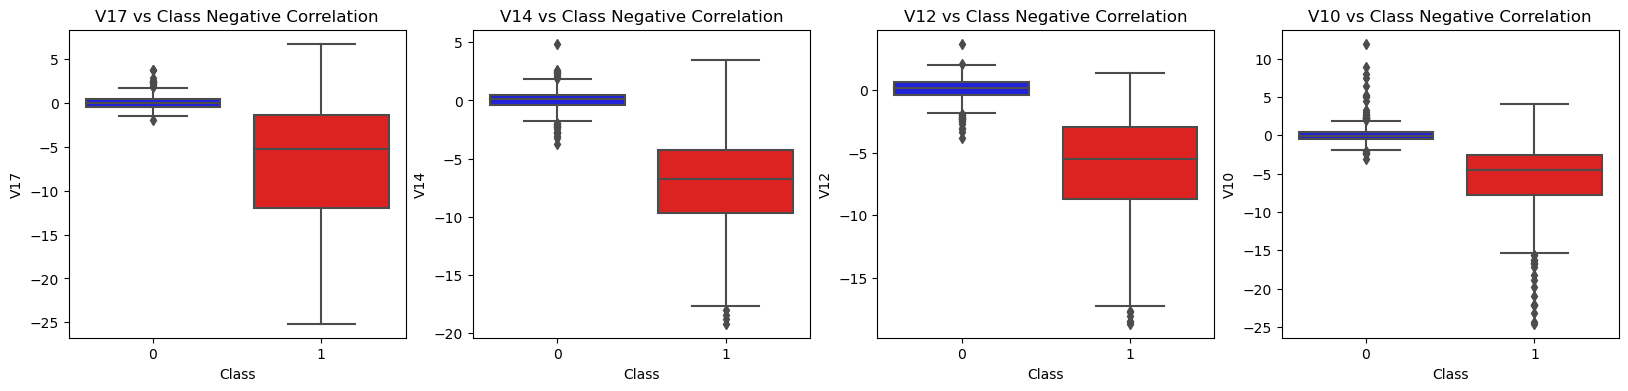

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction) tquan ttinh âm
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

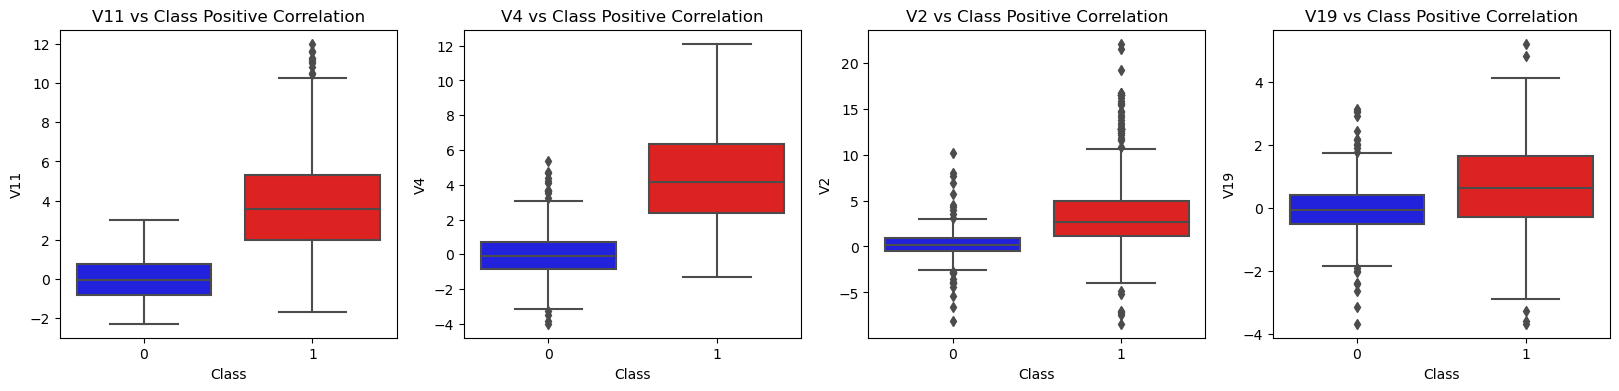

In [17]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction) tquan ttinh âm
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## 2.4. Anomaly Detection:
Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>

### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>

**Note:** After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.

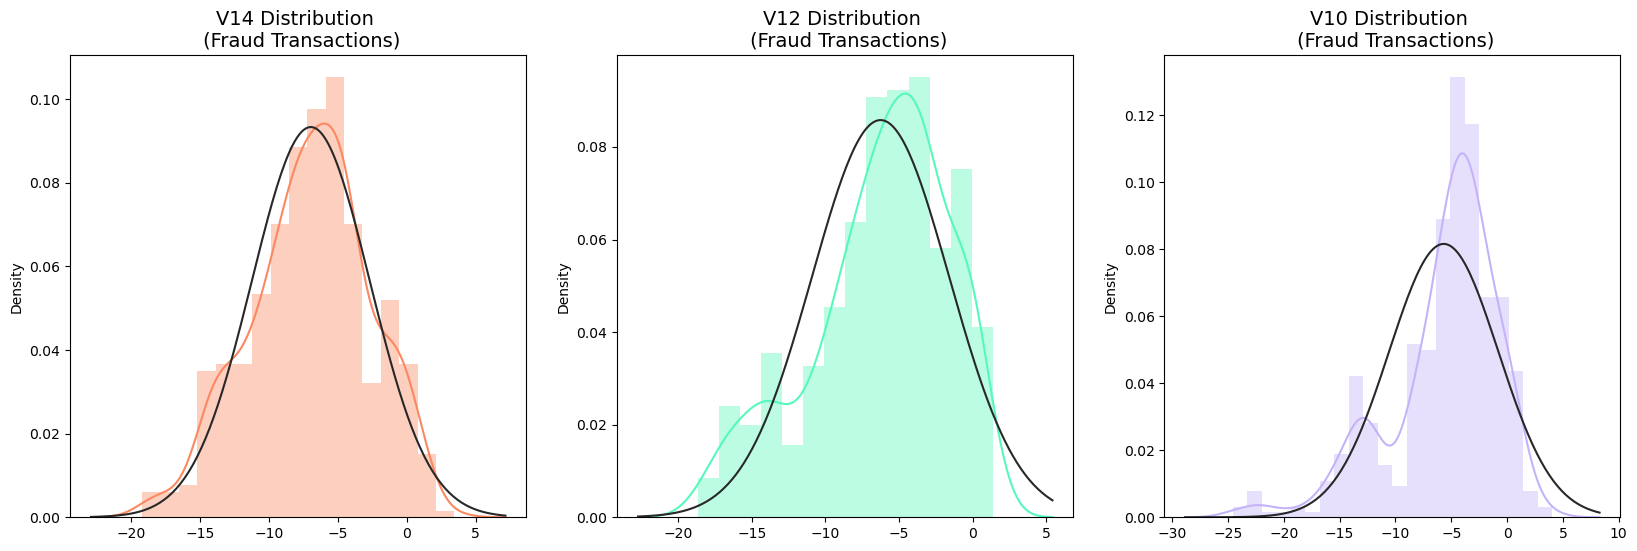

In [18]:
#đường đen là normal, đường màu là true distribution
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [15]:
def remove_outliers(df: pd.DataFrame, feat: str):
    """
    """
    feat_fraud = df[feat].loc[df['Class'] == 1].values
    q25, q75 = np.percentile(feat_fraud, 25), np.percentile(feat_fraud, 75)
    iqr = q75 -q25 #IQR (viết tắt của "interquartile range") là độ trải giữa hay còn gọi là khoảng tứ phân vị của tập dữ liệu. 
    
    cut_off = iqr * 1.5 # công thức box plot
    lower, upper = q25 - cut_off, q75 + cut_off

    outliers = [x for x in feat_fraud if x < lower or x > upper]
    print(f'Feature {feat} Outliers for Fraud Cases: {len(outliers)}')

    return df.drop(df[(new_df[feat] > upper) | (df[feat] < lower)].index)

In [16]:
new_df = remove_outliers(new_df, 'V14')
new_df = remove_outliers(new_df, 'V12')
new_df = remove_outliers(new_df, 'V10')

Feature V14 Outliers for Fraud Cases: 4
Feature V12 Outliers for Fraud Cases: 4
Feature V10 Outliers for Fraud Cases: 27


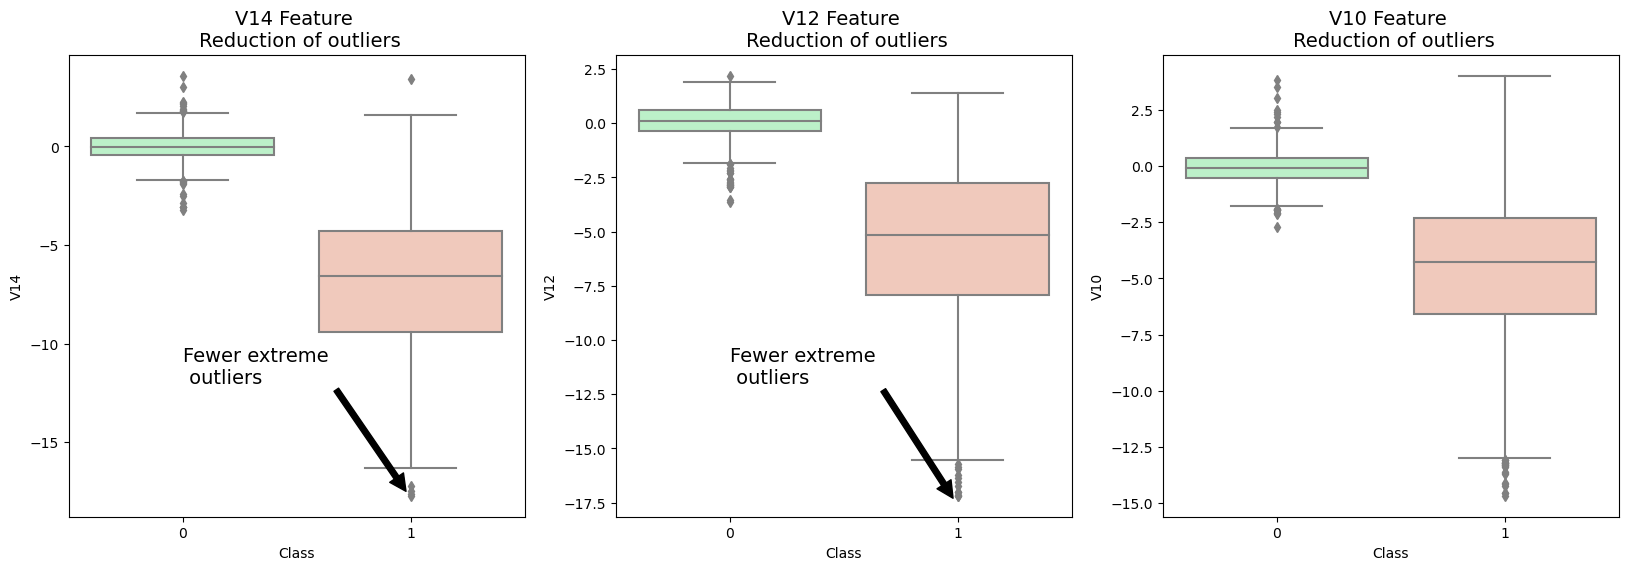

In [17]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## 2.5. Dimensionality Reduction and Clustering
### Summary:
<ul> 
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario.
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

In [22]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values) #giảm chiều dữ liệu còn 2 chiều, chỉ plot chứ ko fit mô hình
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.2 s
PCA took 0.005 s
Truncated SVD took 0.003 s


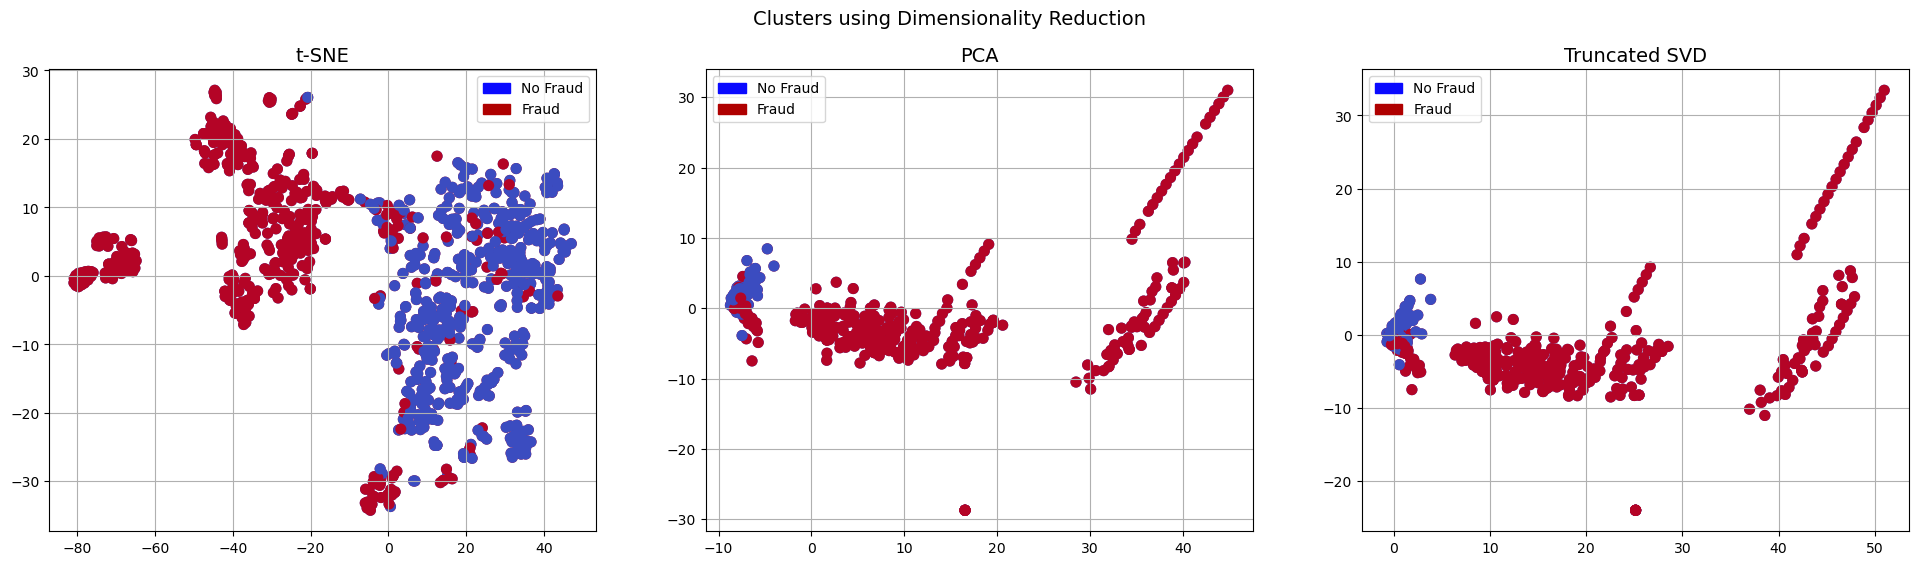

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot giống PCA
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# 3. Model developpment

## 3.1 Classifiers with UnderSampling
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>. Before we have to split our data into training and testing sets and separate the features from the labels.

Phân loại Classifiers (Logistic, NaiveBayes) hay Regression

## Summary: 
<ul>
<li> <b> Logistic Regression </b> classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression) </li>
<li><b> GridSearchCV </b> is used to determine the paremeters that gives the best predictive score for the classifiers. </li>
<li> Logistic Regression has the best Receiving Operating Characteristic score  (ROC), meaning that LogisticRegression pretty accurately separates <b> fraud </b> and <b> non-fraud </b> transactions.</li>
</ul>

## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

In [18]:
# Undersampling before cross validating
X_under = new_df.drop('Class', axis=1)
y_under = new_df['Class']

In [19]:
# This is explicitly used for undersampling.
X_un_train, X_un_test, y_un_train, y_un_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [20]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

#sd .fit, .predict

In [21]:
for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X_un_train, y_un_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 5) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 93.642 % accuracy score
Classifiers:  KNeighborsClassifier has a training score of 91.92099999999999 % accuracy score
Classifiers:  SVC has a training score of 92.318 % accuracy score
Classifiers:  DecisionTreeClassifier has a training score of 90.861 % accuracy score


## GridSearch for Logistic & SVC

In [22]:
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_un_train, y_un_train)
log_reg = grid_log_reg.best_estimator_


# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_un_train, y_un_train)
svc = grid_svc.best_estimator_

In [23]:
log_reg_score = cross_val_score(log_reg, X_un_train, y_un_train, cv=5)
print('Logistic Regression Cross Validation Score:', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_un_train, y_un_train, cv=5)
print('Support Vector Classifier Cross Validation Score:', round(svc_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score: 93.64%
Support Vector Classifier Cross Validation Score: 93.38%


In [25]:
def plot_learning_curve(
        estimator1, 
        estimator2, 
        X, 
        y, 
        ylim=None, 
        cv=None, 
        train_sizes=np.linspace(.1, 1.0, 5)
    ) -> None:
    """Plot learning curve.

    Args:
        estimator1: model 1
        estimator2: model 2
        X: training data
        y: training label
        ylim: limit of y
        cv: cross-validation
        train_sizes: list of train/test ratio

    Returns:
        Plot
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
        
    # Logis
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # SVC, giải thuật SVM bằng sklearn, SVM là một thuật toán giám sát, nó có thể sử dụng cho cả việc phân loại hoặc đệ quy.
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

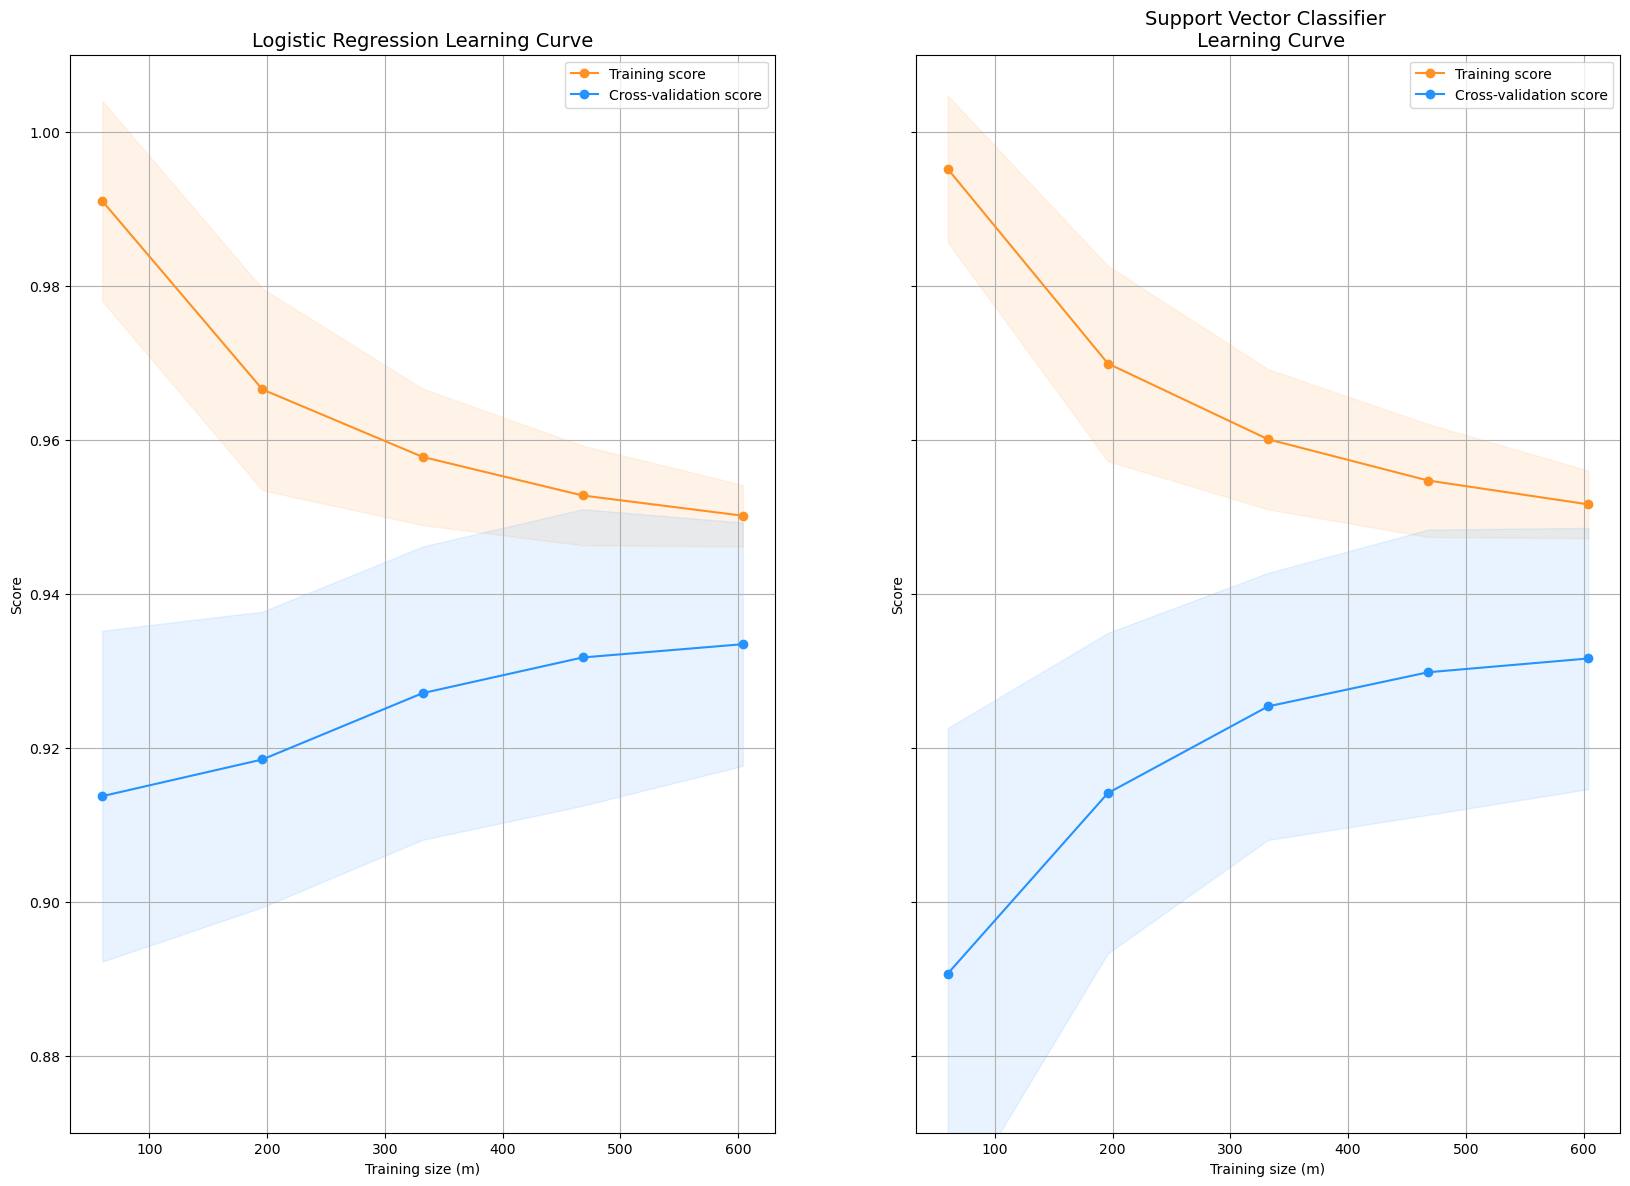

In [26]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, svc, X_un_train, y_un_train, (0.87, 1.01), cv=cv)
plt.show()
#đường cam là train, đường xanh là test, khoảng cách giữa 2 đường là dao động giữa 5 lần huấn luyện
# train thì có càng nhiều dữ liệu càng giảm vì mô hình càng có nhiều điểm càng khó fit hết, test thì càng có thêm càng tăng vì test phải có để học

In [28]:
# Create a DataFrame with all the scores and the classifiers names.
log_reg_pred = cross_val_predict(log_reg, X_un_train, y_un_train, cv=5,
                             method="decision_function")

svc_pred = cross_val_predict(svc, X_un_train, y_un_train, cv=5,
                             method="decision_function")

## roc_auc metric
vì accu là 1 thang đo tệ cho dataset lệch, nên ta sử dụng roc_auc_score

roc dựa trên recall và precision, diện tích càng gần 1 càng tốt

In [29]:
# Calculate roc_auc metric
print('Logistic Regression: ', roc_auc_score(y_un_train, log_reg_pred))
print('Support Vector Classifier: ', roc_auc_score(y_un_train, svc_pred))

Logistic Regression:  0.9706101190476191
Support Vector Classifier:  0.9706662735849056


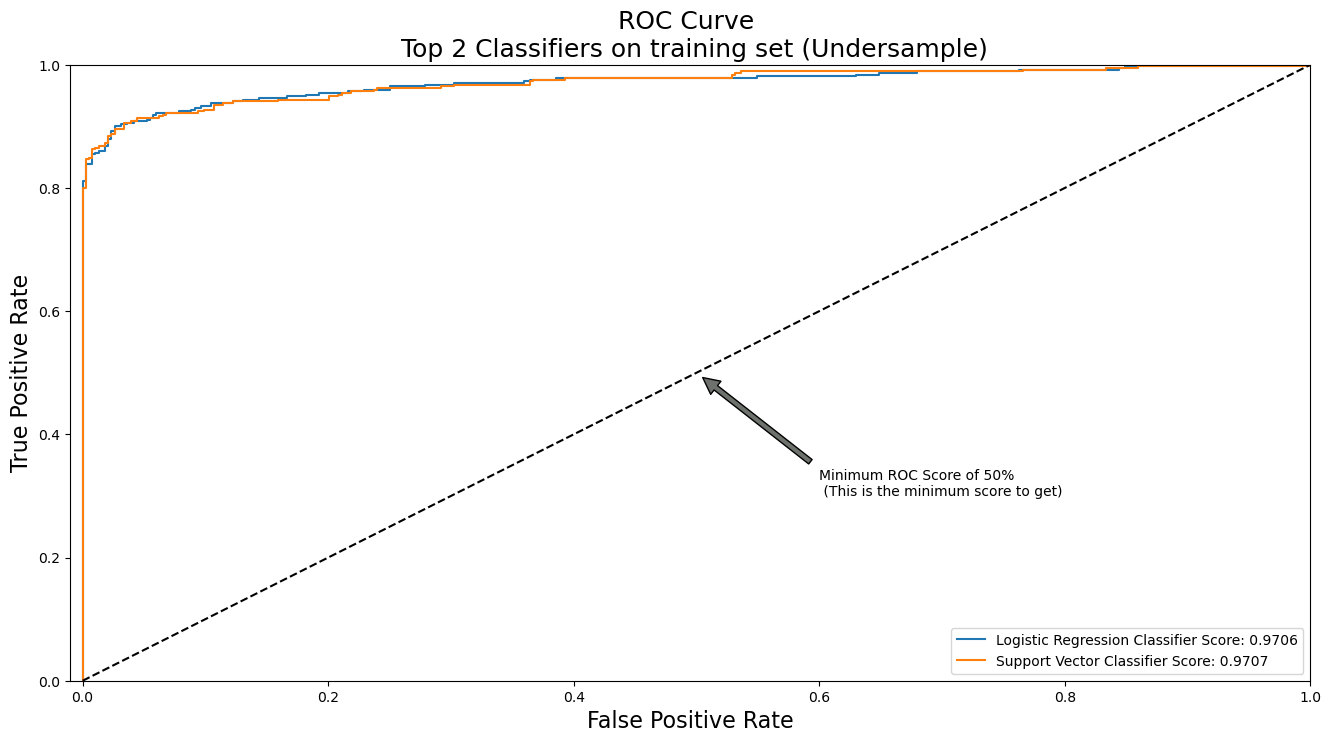

In [30]:
log_fpr, log_tpr, log_thresold = roc_curve(y_un_train, log_reg_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_un_train, svc_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, ):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 2 Classifiers on training set (Undersample)', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_un_train, log_reg_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_un_train, svc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr)
plt.show()

## 3.2. A Deeper Look into LogisticRegression

### Terms:
<ul>
<li><b>True Positives:</b> Correctly Classified Fraud Transactions </li>
<li><b>False Positives:</b> Incorrectly Classified Fraud Transactions</li>
<li> <b>True Negative:</b> Correctly Classified Non-Fraud Transactions</li>
<li> <b>False Negative:</b> Incorrectly Classified Non-Fraud Transactions</li>
<li><b>Precision: </b>  True Positives/(True Positives + False Positives)  </li>
<li><b> Recall: </b> True Positives/(True Positives + False Negatives)   </li>
</ul>

Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.</li>

<b>Precision/Recall Tradeoff: </b> The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect.

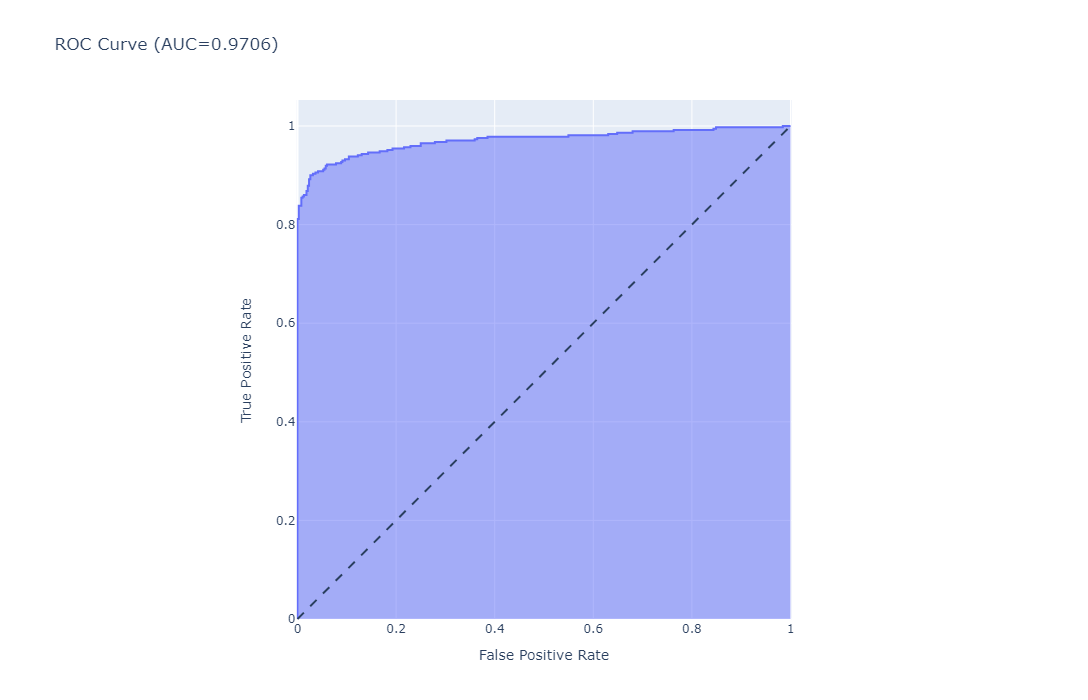

In [31]:
fig = px.area(
    x=log_fpr, y=log_tpr,
    title=f'ROC Curve (AUC={auc(log_fpr, log_tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=700
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


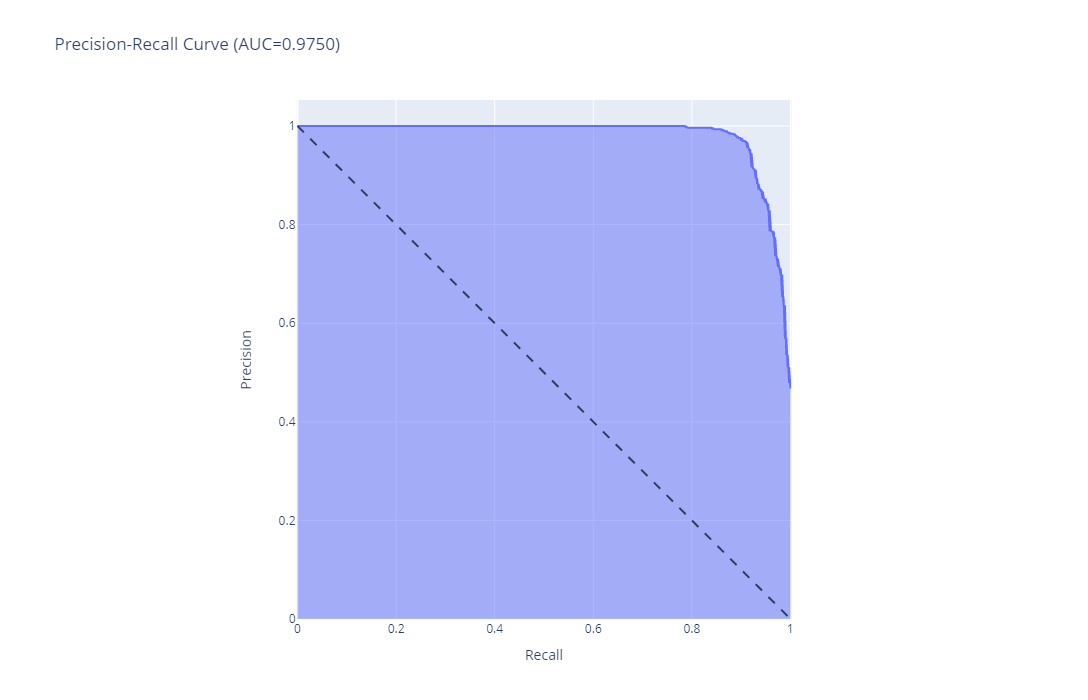

In [57]:
log_pre, log_recall, log_thresholds = precision_recall_curve(y_un_train, log_reg_pred)
fig = px.area(
    x=log_recall, y=log_pre,
    title=f'Precision-Recall Curve (AUC={auc(log_fpr, log_tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=700
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

## 3.3 Classifiers with OverSampling

In [33]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

Length of X (train): 227845 | Length of y (train): 227845
Length of X (test): 56962 | Length of y (test): 56962


## SMOTE
SMOTE (Synthetic Minority Over-sampling) và ADASYN (Adaptive synthetic sampling) là các phương pháp sinh mẫu nhằm gia tăng kích thước mẫu của nhóm thiểu số trong trường hợp xảy ra mất cân bằng mẫu.
Sinh mẫu dựa trên các cụm gần nhau (clustering)

In [34]:
sss = StratifiedShuffleSplit(n_splits=5)

In [35]:
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(log_reg_sm, log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain.iloc[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain.iloc[test], prediction))
    precision_lst.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_lst.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_lst.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain.iloc[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 0.06672964333786797
recall: 0.9282051282051281
f1: 0.1244850688189599
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
accu = 1 vì dữ liệu bị lệch, recall cao precision thấp tỷ lệ nghịch, f1 thấp vì tính dựa trên recall và presicion 

In [45]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56864
       Fraud       0.06      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [38]:
y_score = best_est.decision_function(original_Xtest)

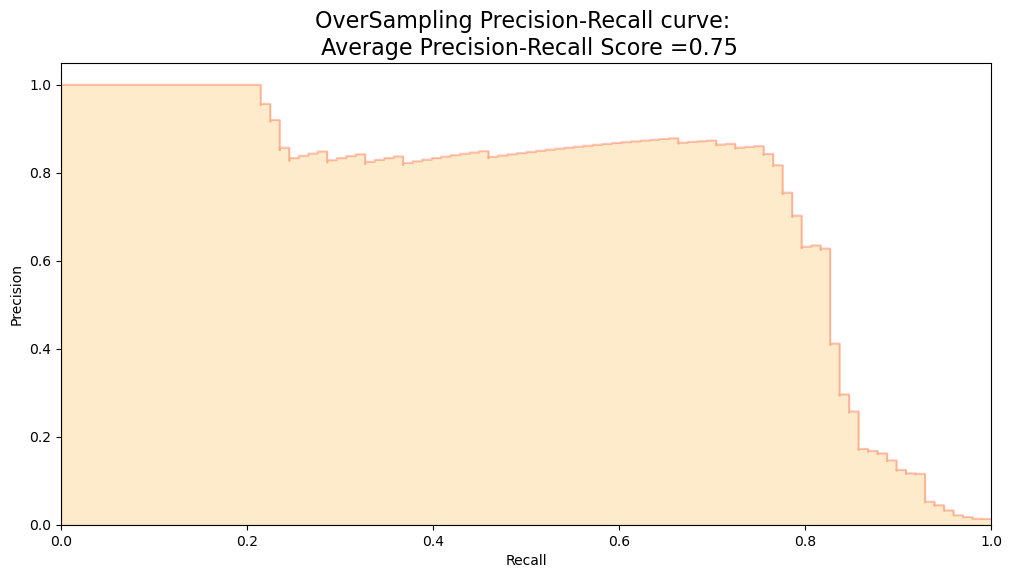

In [46]:
fig = plt.figure(figsize=(12,6))
average_precision = average_precision_score(original_ytest, y_score)
precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

plt.show()

# 4. Testing phase (Logistic Regression)

#### Confusion Matrix
- True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class. <br><br>
- False Negatives (Top-Right Square):** This is the number of **incorrectly** classifications of the "No"(No Fraud Detected) class. <br><br>
- False Positives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (Fraud Detected) class <br><br>
- True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.

#### We will evaluate the final performance of the classification models in the <b>random undersampling subset</b>.

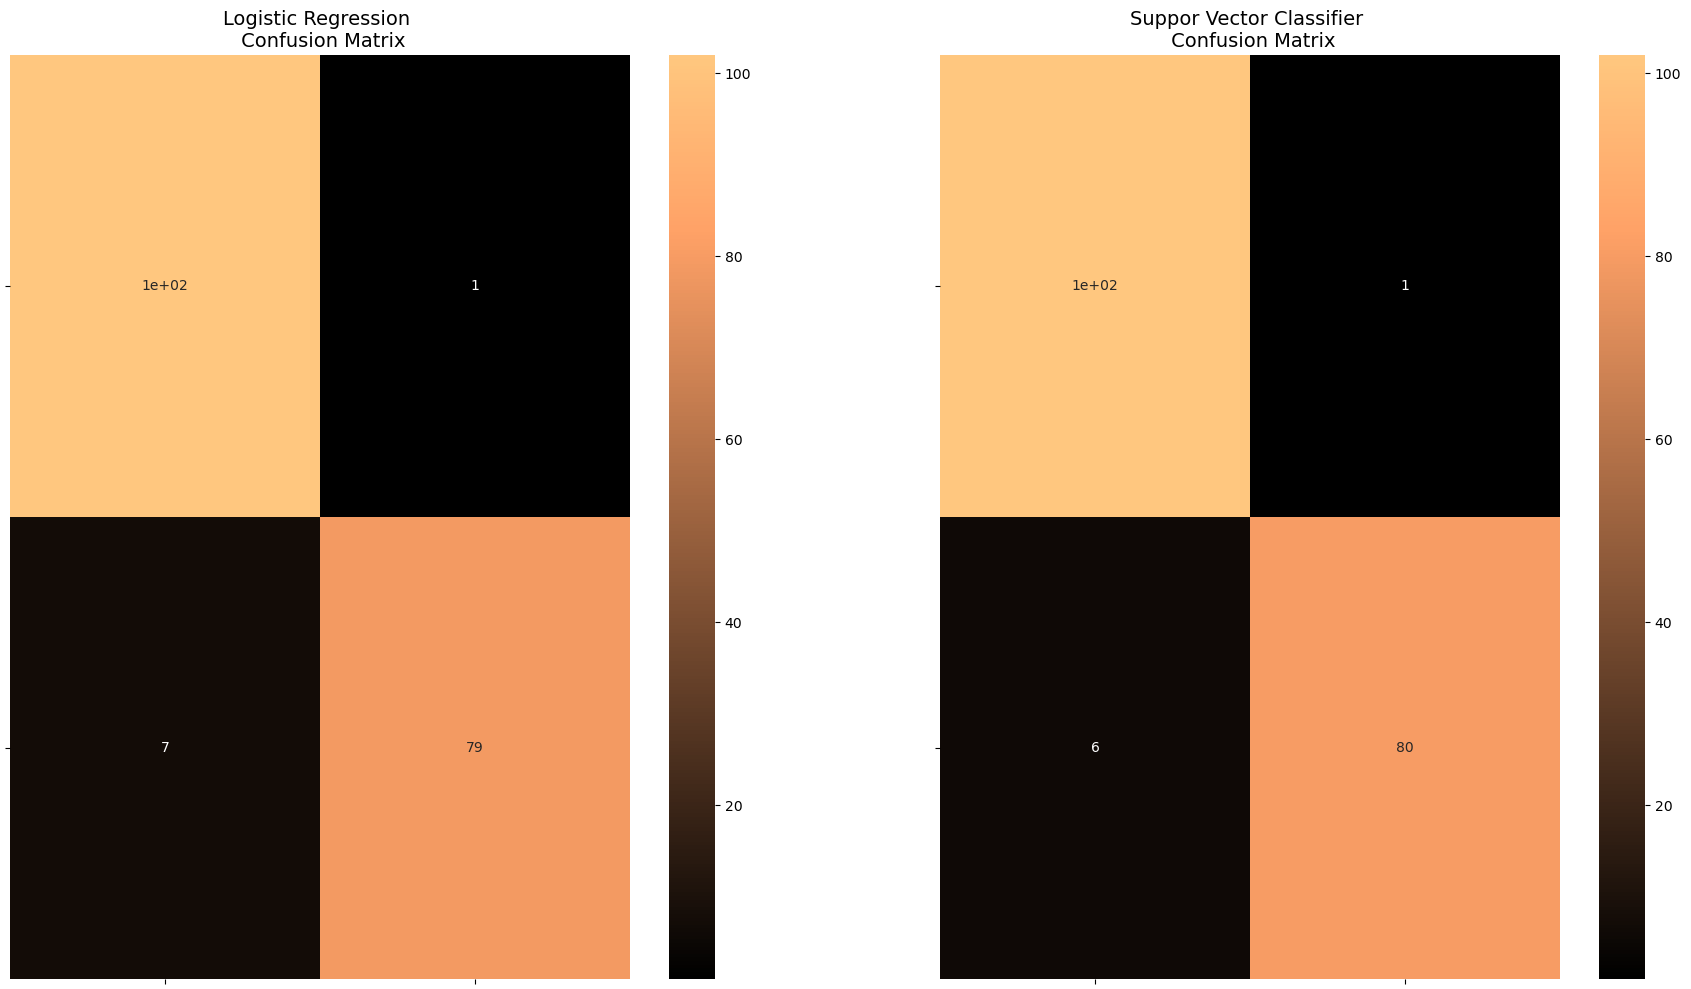

In [47]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = best_est.predict(X_un_test)

# Other models fitted with UnderSampling
y_pred_svc = svc.predict(X_un_test)


log_reg_cf = confusion_matrix(y_un_test, y_pred_log_reg)
svc_cf = confusion_matrix(y_un_test, y_pred_svc)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax1, annot=True, cmap=plt.cm.copper)
ax1.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax1.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax1.set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax2, annot=True, cmap=plt.cm.copper)
ax2.set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax2.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax2.set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [48]:
print('Logistic Regression:')
print(classification_report(y_un_test, y_pred_log_reg))

print('Support Vector Classifier:')
print(classification_report(y_un_test, y_pred_svc))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       103
           1       0.99      0.92      0.95        86

    accuracy                           0.96       189
   macro avg       0.96      0.95      0.96       189
weighted avg       0.96      0.96      0.96       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       103
           1       0.99      0.93      0.96        86

    accuracy                           0.96       189
   macro avg       0.97      0.96      0.96       189
weighted avg       0.96      0.96      0.96       189



In [49]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(original_Xtest)
undersample_score = accuracy_score(original_ytest, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Accuracy', score)

final_df

Technique     Score
0  Random UnderSampling  0.969541
1  Oversampling (SMOTE)  0.973754

In [49]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(original_Xtest)
undersample_score = accuracy_score(original_ytest, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Accuracy', score)

final_df

Technique  Accuracy
0  Random UnderSampling  0.969366
1  Oversampling (SMOTE)  0.975844

### cách lưu model thành file để share
https://scikit-learn.org/stable/model_persistence.html

Đây là cách đơn giản nhất

Triển khai dự án trên thực tế sử dụng cách phức tạp hơn, cần tự tìm hiểu thêm

In [55]:
#c1: lưu mô hình thành file pickle (.pkl)
#c2: phức tạp hơn 
import pickle

with open('luu_model.pkl', 'wb') as handle:
    pickle.dump(best_est, handle, protocol = pickle. HIGHEST_PROTOCOL)

In [56]:
with open('luu_model.pkl', 'rb') as handle:
    savedmodel = pickle.loads('luu_model.pkl')

TypeError: a bytes-like object is required, not 'str'

In [ ]:
savedmodel.predict...

# 5. How/why does the model predict

For the people who use your model to solve problem, they really don't care about how *good* that model is (MAE, MSE, accuracy, ...). They are more interested in why the model predicts that value or what factors or features help the model predict the value.

Giải thích cho enduser tại sao lại ra kết quả dự đoán đó - tính đạo đức của 1 mô hình AI, có dùng được hay không

<b>Interpretability (Model overall)</b>: focuses on understanding the internal workings of AI models and algorithms. It aims to provide insights into how the model processes input data and generates output predictions. Interpretable models allow humans to examine the model's features, parameters, or decision-making process to gain insights and build trust in the model's behavior.

<b>Explainability (Specific prediction)</b>: make complex models or algorithms more transparent, allowing humans to understand the factors or features that contribute to a particular decision or prediction.

Some libraries you should consider: LIME, SHAP, DeepLIFT, ELI5, AIX360

https://shap.readthedocs.io/en/latest/index.html

In [50]:
!conda install -c conda-forge shap

^C


In [57]:
conda install shap

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\1ftu\SATELLITE\FDC104\Anaconda\Setup

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    shap-0.41.0                |   py39hf11a4ad_0         552 KB
    slicer-0.0.7               |     pyhd3eb1b0_0          18 KB
    ------------------------------------------------------------
                                           Total:         570 KB

The following NEW packages will be INSTALLED:

  shap               pkgs/main/win-64::shap-0.41.0-py39hf11a4ad_0 None
  slicer             pkgs/main/noarch::slicer-0.0.7-pyhd3eb1b0_0 None




shap-0.41.0          | 552 KB    |            |   0% 
shap-0.41.0          | 552 KB    | 2          |   3% 
shap-0.41.0          | 552 KB    | #1         |  12% 
shap-0.41.0          | 552 KB    | ##6        |  26% 
shap-0.41.0          | 



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [58]:
#shap value trong R cũng có
import shap

In [59]:
explainer = shap.Explainer(best_est, original_Xtrain)
shap_values = explainer(original_Xtest)

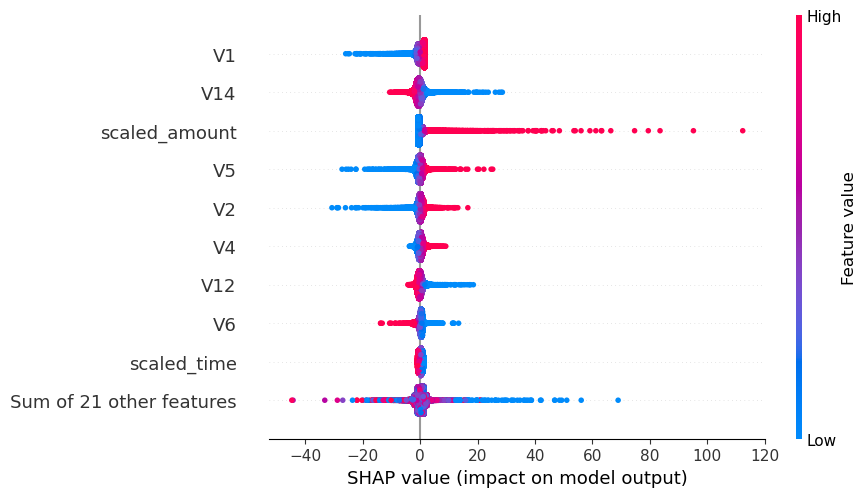

In [60]:
shap.plots.beeswarm(shap_values)

In [61]:
shap.initjs()
shap.plots.force(shap_values[0])

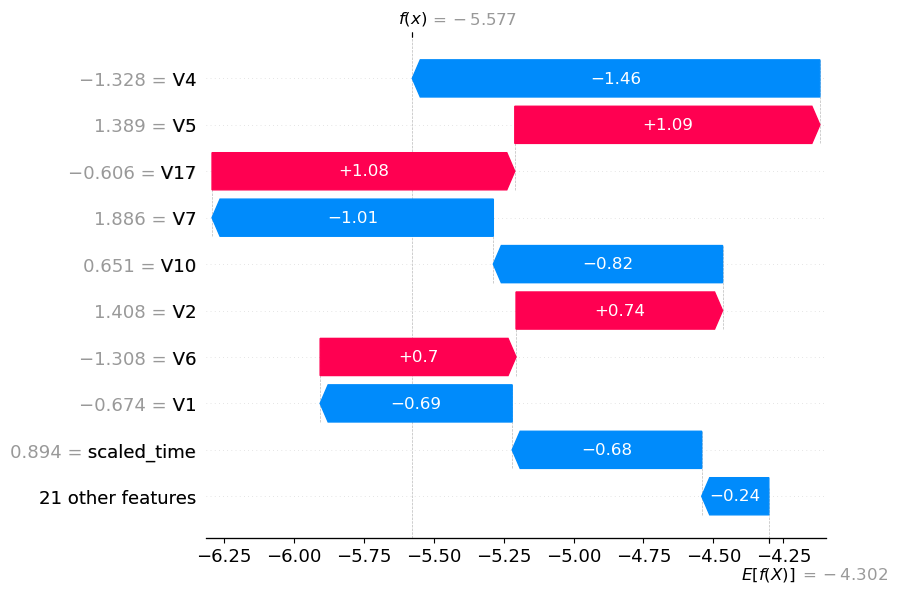

In [56]:
shap.plots.waterfall(shap_values[0])